# VIME: Self/Semi Supervised Learning for Tabular Data

# Setup

In [1]:
import sys


In [2]:
sys.path.insert(0, '/home/lic776//Desktop/SIBMI/modified_umap')
directory_to_remove = '/home/lic776/Desktop/SIBMI/vime_refactored'
if directory_to_remove in sys.path:
    print("it is there")
    sys.path.remove(directory_to_remove)
sys.path.append('/home/lic776/Desktop/SIBMI/')
print(sys.path)

import umap as mp


['/home/lic776//Desktop/SIBMI/modified_umap', '/usr/lib64/python36.zip', '/usr/lib64/python3.6', '/usr/lib64/python3.6/lib-dynload', '', '/home/lic776/Desktop/SIBMI/.venv/lib64/python3.6/site-packages', '/home/lic776/Desktop/SIBMI/.venv/lib/python3.6/site-packages', '/home/lic776/Desktop/SIBMI/.venv/lib64/python3.6/site-packages/IPython/extensions', '/home/lic776/.ipython', '/home/lic776/Desktop/SIBMI/']


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib_metadata
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (average_precision_score, mean_squared_error,
                             roc_auc_score)
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from vime_refactored.vime import VIME, VIME_Self
from vime_refactored.vime_data import (
    labelled_loss_fn, mask_generator_tf,
    pretext_generator_tf, semi_supervised_generator,
    to_vime_dataset, unlabelled_loss_fn
)
from sklearn.preprocessing import LabelEncoder
import copy


In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = (20,10)

# Data

We're going to be using IEEE-CIS Fraud detection dataset from Kaggle. The dataset was already pre-processed and can be downloaded from [Kaggle](https://www.kaggle.com/datasets/antonsruberts/fraud-detection-preprocesed). If you want to know about the pre-processing process or yopu want to change something, feel free to take a look at the `Fraud Data Unsupervised Preprocessing` notebook.
The example data is taken from [Kaggle](https://www.kaggle.com/c/ieee-fraud-detection) but it's already pre-processed and ready to be used. You can checkout the pre-processing notebook in the same folder to get some understanding about what transformations were done to the features.

In [5]:
df = pd.read_csv('/home/lic776/Desktop/SIBMI/merged_data_sub_10.csv')

# Further preparing the data 
# Drop irrelevant columns
columns_to_drop = ["SDMVPSU", "SDMVSTRA", "WTMEC4YR", "SDDSRVYR", "RIDSTATR", "WTSCY4YR"] # "eGFR", "eGFR_no_race", "change_in_eGFR"]
df = df.drop(columns=columns_to_drop)
# Encode categorical variables
label_encoders = {}
for column in ["RIAGENDR", "RIDRETH2", "RIDEXPRG"]:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

# separating and printing shapes
labeled_data = df[df['simulated_mGFR'].notna()]
unlabeled_data = df[df['simulated_mGFR'].isna()]

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# from semisupervised.ipynb, but we actually want X
X_labeled = labeled_data.drop(columns=['simulated_mGFR'])
y_labeled = labeled_data['simulated_mGFR']
X_unlabeled = unlabeled_data.drop(columns=['simulated_mGFR'])

X = pd.concat([X_labeled, X_unlabeled], ignore_index=True)

print(X.shape)

(4262, 51)


In [6]:
my_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('std_scaler', StandardScaler())
])




# Splitting X into training and test sets for labeled data
X_train_labeled, X_test_labeled, y_train_labeled, y_test_labeled = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)

# # Fit and transform X_train_labeled
X_train_labeled = my_pipeline.fit_transform(X_train_labeled)
X_train_labeled = pd.DataFrame(X_train_labeled)

# Transform X_test_labeled and X_unlabeled
X_test_labeled= my_pipeline.transform(X_test_labeled)
X_test_labeled_ = pd.DataFrame(X_test_labeled)
X_unlabeled = my_pipeline.transform(X_unlabeled)
X_unlabeled = pd.DataFrame(X_unlabeled)

print(X_train_labeled.shape, X_test_labeled.shape)


(340, 51) (86, 51)


In [7]:
# val? 
X_train_labeled_copy = copy.deepcopy(X_train_labeled)
y_train_labeled_copy = copy.deepcopy(y_train_labeled)
X_train_labeled, X_val_labeled, y_train_labeled, y_val_labeled = train_test_split(X_train_labeled_copy, y_train_labeled_copy, test_size=0.1, random_state=42)
X_train_unlabeled, X_val_unlabeled = train_test_split(X_unlabeled, test_size=0.1, random_state=42)

print("Labelled train, val, test: ", X_train_labeled.shape, X_val_labeled.shape, X_test_labeled.shape)
print("unlabelled train, val: ", X_train_unlabeled.shape, X_val_unlabeled.shape)
print("X_unlabeled: ", X_unlabeled.shape)
print(
    "Labelled Proportion:", 
    np.round((X_train_labeled.shape[0]) / (X_unlabeled.shape[0] + X_train_labeled.shape[0]), 5)
) # should be .07388

Labelled train, val, test:  (306, 51) (34, 51) (86, 51)
unlabelled train, val:  (3452, 51) (384, 51)
X_unlabeled:  (3836, 51)
Labelled Proportion: 0.07388


The following model will be trained with these hyperparameters:

In [8]:
vime_params = {
    'alpha': 4, # importance of feature loss = more diverse
    'beta': 10,  # originally 10, importance of labeled loss
    'k': 5, 
    'p_m': 0.36
}

## Self-Supervised Learning

### Data Prep

The model needs 1 input - corrupted X, and 2 outputs - mask and original X. 

In [9]:
print(np.any(np.isnan(X_train_unlabeled)))
print(np.any(np.isinf(X_train_unlabeled)))
print(np.any(np.isnan(X_val_unlabeled)))
print(np.any(np.isinf(X_val_unlabeled)))

zero_variance_features = (X_train_unlabeled.var() == 0).sum()
if zero_variance_features > 0:
    print(f"Warning: {zero_variance_features} features have zero variance.")



False
False
False
False


In [45]:
batch_size = 32

# Datasets
train_ds, train_m = to_vime_dataset(X_train_unlabeled, vime_params['p_m'], batch_size=batch_size, shuffle=True)
val_ds, val_m = to_vime_dataset(X_val_unlabeled, vime_params['p_m'], batch_size=batch_size)
num_features = X_train_unlabeled.shape[1]

print('Proportion Corrupted:', np.round(train_m.numpy().mean(), 2))

# Training
vime_s = VIME_Self(num_features)
vime_s.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    loss={
        'mask': 'binary_crossentropy', 
        'feature': 'mean_squared_error'},
    loss_weights={'mask':1, 'feature': vime_params['alpha']} # mask weight originally 1
)

cbs = [tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )]

vime_s.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1000,
    callbacks=cbs
)

vime_s.save('./vime_self')

Proportion Corrupted: 0.31
Epoch 1/1000
108/108 [==============================] - 2s 5ms/step - loss: 4.9479 - feature_loss: 1.0743 - mask_loss: 0.6506 - val_loss: 3.3637 - val_feature_loss: 0.6856 - val_mask_loss: 0.6214
Epoch 2/1000
108/108 [==============================] - 0s 2ms/step - loss: 3.4261 - feature_loss: 0.7013 - mask_loss: 0.6208 - val_loss: 2.7787 - val_feature_loss: 0.5423 - val_mask_loss: 0.6095
Epoch 3/1000
108/108 [==============================] - 0s 2ms/step - loss: 2.9654 - feature_loss: 0.5887 - mask_loss: 0.6107 - val_loss: 2.5509 - val_feature_loss: 0.4871 - val_mask_loss: 0.6027
Epoch 4/1000
108/108 [==============================] - 0s 2ms/step - loss: 2.7522 - feature_loss: 0.5369 - mask_loss: 0.6045 - val_loss: 2.4430 - val_feature_loss: 0.4611 - val_mask_loss: 0.5987
Epoch 5/1000
108/108 [==============================] - 0s 2ms/step - loss: 2.6263 - feature_loss: 0.5065 - mask_loss: 0.6004 - val_loss: 2.3597 - val_feature_loss: 0.4407 - val_mask_loss: 

In [46]:
vime_s = tf.keras.models.load_model('./vime_self')

### Evaluation

All the evaluation will be done on the validation set

In [47]:
val_self_preds = vime_s.predict(val_ds)

To evaluate the mask reconstruction ability we can simply check the ROC AUC score for mask predictions across all the features. 

In [48]:
feature_aucs = []
for i in tqdm(range(X_val_unlabeled.shape[1])):
    roc = roc_auc_score(val_m.numpy()[:, i], val_self_preds['mask'][:, i])
    feature_aucs.append(roc)

100%|██████████| 51/51 [00:00<00:00, 666.25it/s]


In [35]:
print(feature_aucs)

[0.5331940298507463, 0.8278351457552773, 0.6522659305268002, 0.54315185546875, 0.575721103963478, 0.5159241646852709, 0.5432132542939656, 0.5432844593932665, 0.5287001897533208, 0.4850959457509739, 0.4980217164956121, 0.49118562046318703, 0.5656003299163426, 0.5719396344396344, 0.5419431205806311, 0.5478294853294853, 0.4901588163431519, 0.43626889601465874, 0.5122828784119107, 0.5228877921924406, 0.5470332428567258, 0.5131373256373257, 0.4931940298507463, 0.4908008658008658, 0.48123633014849776, 0.5017282384651974, 0.5120347394540943, 0.5169877526232328, 0.5228877921924406, 0.5066119471044233, 0.4971487191865553, 0.5137571157495255, 0.49563709746184237, 0.48666686011084354, 0.4968789013732833, 0.508636474609375, 0.5323821339950372, 0.4875620347394541, 0.593667876360906, 0.5347222222222222, 0.745952877063632, 0.8981481481481481, 0.7938179347826088, 0.8983844011142061, 0.4650122637426057, 0.4847443301873503, 0.5237719989493039, 0.5308010852491789, 0.6965495755121115, 0.5436119402985073, 

In [36]:
self_metrics = pd.DataFrame({"metric": 'mask_auc', 
             "metric_values": feature_aucs})

Now, we can evaluate the feature reconstruction ability using RMSE and correlation coefficients

In [37]:
input_feature_variances = np.var(X_val_unlabeled.values, axis=0)
print("Input Feature Variances:", input_feature_variances)

# Calculate variances for predicted features
predicted_feature_variances = np.var(val_self_preds['feature'], axis=0)
print("Predicted Feature Variances:", predicted_feature_variances)

# Check if any input features have zero variance
zero_variance_input_features = np.sum(input_feature_variances == 0)
print(f"Number of input features with zero variance: {zero_variance_input_features}")

# Check if any predicted features have zero variance = model not learning useful representatois
zero_variance_predicted_features = np.sum(predicted_feature_variances == 0)
print(f"Number of predicted features with zero variance: {zero_variance_predicted_features}")

# Compute feature correlations, handling potential issues
feature_corrs = []
for i in tqdm(range(X_val_unlabeled.shape[1])):
    feature = X_val_unlabeled.values[:, i]
    pred_feature = val_self_preds['feature'][:, i]
    
    # Check for zero variance in feature or predicted feature
    if np.var(feature) == 0:
        print(f"Feature {i} var 0 in input")
        c = np.nan 
    elif np.var(pred_feature) == 0:
        print(f"Feature {i} var 0 in predictions")
        c = np.nan  # Assign NaN if variance is zero
    else:
        c = np.corrcoef(feature, pred_feature)[0, 1]
    feature_corrs.append(c)
    
self_metrics = pd.concat([
    self_metrics,
    pd.DataFrame({"metric": 'feature_correlation', 
             "metric_values": feature_corrs})
])

Input Feature Variances: [1.16522322 1.07327946 1.01392506 0.89348693 0.98376629 0.88311837
 0.88311837 0.298112   0.36550703 0.67576127 0.61159076 0.61147459
 1.12293132 1.12293132 1.13910682 1.13840739 1.17011885 2.64022837
 0.62725405 0.62725967 0.89443342 0.8944523  0.80402999 1.00871042
 1.00984647 1.23031177 1.23167011 0.95594694 0.95594694 0.7148636
 0.71483385 0.79870448 0.79872398 0.69444951 1.21589875 0.88359092
 1.05032396 1.07630963 0.88258804 0.88258804 1.66453083 1.66453083
 0.93080668 0.93080668 0.79718774 0.67039593 0.80915833 0.80319041
 0.84790618 0.87498147 1.17199355]
Predicted Feature Variances: [0.5079805  0.67349935 0.4953486  0.619278   0.39224532 0.55317044
 0.555481   0.24996616 0.28423503 0.34483448 0.5580681  0.55969423
 0.60424453 0.60515463 0.62292033 0.62187064 0.45336542 0.9587545
 0.3604587  0.3624371  0.517693   0.5189845  0.39912534 0.6308407
 0.6334999  0.72253853 0.7205708  0.71244866 0.7125613  0.45848903
 0.45120358 0.47938368 0.48089775 0.6018564

100%|██████████| 51/51 [00:00<00:00, 3136.46it/s]


From the plot and table above, we can see that the model has learned to reconstruct most of the features. Half of the features are reconstructed with relatively strong correlation with original data. Only a handful of features are not properly reconstructed. Let's check the RMSE across all the features

In [38]:
rmses = []
for i in tqdm(range(X_val_unlabeled.shape[1])):
    mse = mean_squared_error(X_val_unlabeled.values[:, i], val_self_preds['feature'][:, i])
    rmses.append(np.sqrt(mse))
    
self_metrics = pd.concat([
    self_metrics,
    pd.DataFrame({"metric": 'RMSE', 
             "metric_values": rmses})
])

100%|██████████| 51/51 [00:00<00:00, 2821.17it/s]


In [39]:
print(rmses)

[0.8169839277338848, 0.7428242008946253, 0.7650542958657278, 0.5739430301704908, 0.7621415487654296, 0.6062601973843315, 0.6070288533333087, 0.5865447562202544, 0.5246198435548491, 0.6778783348326091, 0.5228822884039575, 0.5205856749392227, 0.7590831599455966, 0.7581978711753021, 0.7218630851908555, 0.7221904796154784, 0.7921189284139856, 0.9971537576912511, 0.5740834160008202, 0.5751334687735513, 0.6357036633708938, 0.6366764103014604, 0.7181075345593032, 0.7086516039612346, 0.7064517171875047, 0.8099531992301363, 0.8089101997540412, 0.512301241113502, 0.5127064731776187, 0.5099638995392306, 0.5098134544144126, 0.5992669372501322, 0.599947419560358, 0.3477121481297081, 0.7503673833872393, 0.7722617885275836, 0.7579963956332889, 0.6638065562176053, 0.5687123273966498, 0.5680344397446048, 0.6087768248833876, 0.6122004332857489, 0.4690718934619629, 0.4760006654565092, 0.3449540544284385, 0.3408557876640412, 0.4557816080325639, 0.450704157440974, 0.6852023160263149, 0.45133744444498824, 0

Text(0.5, 1.0, 'Self-Supervised VIME Evaluation')

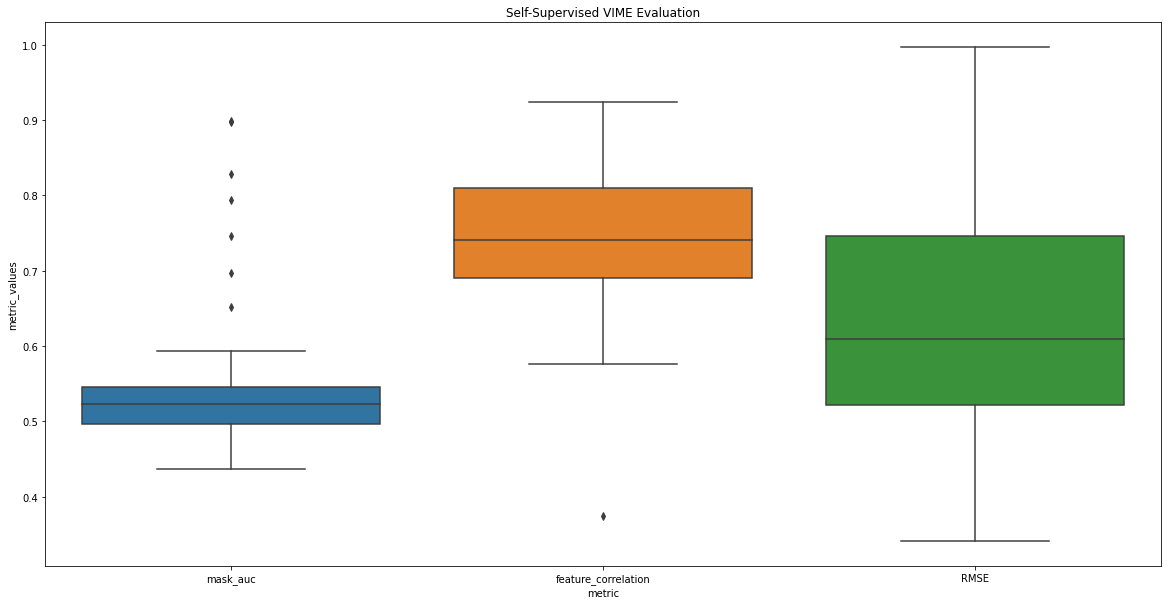

In [40]:
sns.boxplot(x=self_metrics['metric'], y=self_metrics['metric_values'])
plt.title("Self-Supervised VIME Evaluation")

RMSE distribution further indicates that mjority of the features are well-reconstructed.

Another way to evaluate the self-supervised model is to look at the embeddings. Since the whole point of corrupting the dataset is to learn to generate robust embeddings, we can assume that if a sample was corrupted 5 times, all 5 embeddings should be relatively close to each other in the vector space. Let's check this hypothesis by corrupting 10 different samples 5 times and projecting their embeddings to 2-dimensional space using UMAP.

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout


def generate_k_corrupted(x, k, p_m):
    x_u_list = []
    for i in range(k):
        mask = mask_generator_tf(p_m, x)
        _, x_corr = pretext_generator_tf(mask, tf.constant(x, dtype=tf.float32))
        x_u_list.append(x_corr)
    
    
    # Prepare input with shape (n, k, d)
    x_u_corrupted = np.zeros((x.shape[0], k, x.shape[1]))
    for i in range(x.shape[0]):
        for j in range(k):
            x_u_corrupted[i, j, :] = x_u_list[j][i, :]
    
    return x_u_corrupted

In [43]:
vime_s = tf.keras.models.load_model('./vime_self')

# Sequential model to produce embeddings
encoding_model = Sequential(
    [
        Input(num_features),
        vime_s.encoder
    ]
)

dense_model = Sequential(
    [
        Input(num_features),
        Dense(num_features, activation="relu"),
    
    ]
)

# Create corrupted sample
samples = X_val_unlabeled.sample(10)
sample_corrupted = generate_k_corrupted(
    x=samples,
    k=5,
    p_m=0.4
)

val_encoding = encoding_model.predict(sample_corrupted, batch_size=batch_size)
random_encoding = dense_model.predict(sample_corrupted, batch_size=batch_size)

/home/lic776/Desktop/SIBMI/.venv/lib64/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No handles with labels found to put in legend.
/home/lic776/Desktop/SIBMI/.venv/lib64/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


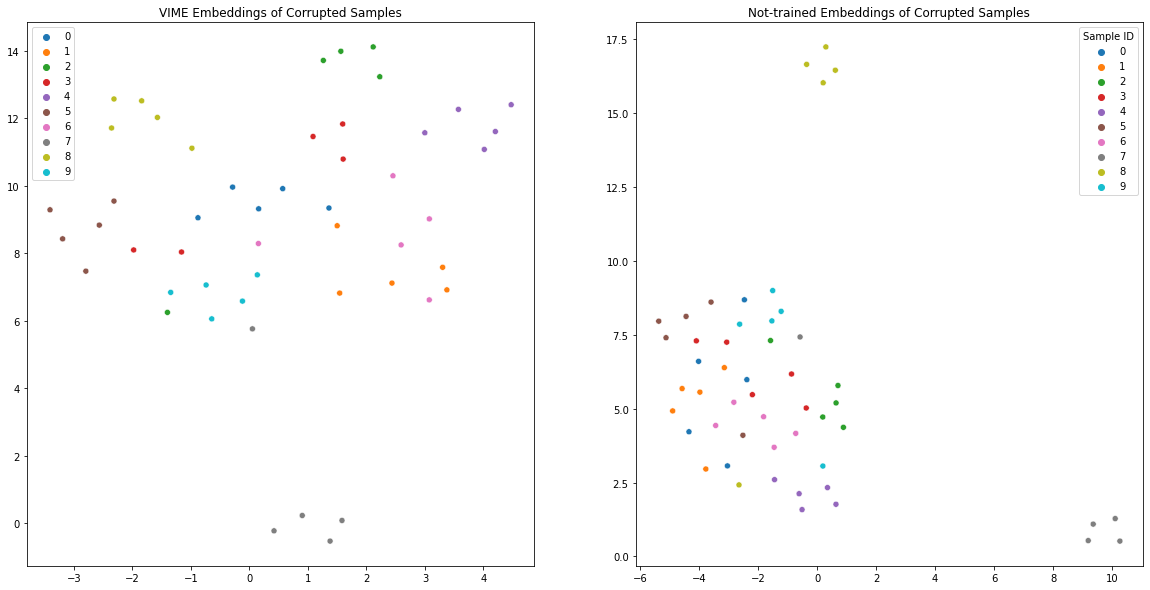

In [44]:
import umap

fig, axs = plt.subplots(1, 2)

# Project corrupted samples
u = umap.UMAP(n_neighbors=5, min_dist=0.8)
corrupted_umap = u.fit_transform(val_encoding.reshape(-1, val_encoding.shape[2]))
sample_ids = np.array([np.repeat(i, 5) for i in range(10)]).ravel()
sns.scatterplot(corrupted_umap[:, 0], corrupted_umap[:, 1], hue=sample_ids, palette="tab10", ax=axs[0])
axs[0].set_title('VIME Embeddings of Corrupted Samples')
plt.legend(title='Sample ID')

# Project corrupted samples
u = umap.UMAP(n_neighbors=5, min_dist=0.8)
corrupted_umap = u.fit_transform(random_encoding.reshape(-1, random_encoding.shape[2]))
sample_ids = np.array([np.repeat(i, 5) for i in range(10)]).ravel()
sns.scatterplot(corrupted_umap[:, 0], corrupted_umap[:, 1], hue=sample_ids, palette="tab10", ax=axs[1])
axs[1].set_title('Not-trained Embeddings of Corrupted Samples')

plt.legend(title='Sample ID')
plt.show()

As you can see, the embeddings indeed put the same samples closer to each other, even though some of their values were corrupted. According to the authors, this means that the model has learned useful information about the feature correlations which can be helpful in the downstream tasks. Now, we can use this encoder in the next semi-supervised part.

## Semi-Supervised Learning

In [56]:
semi_batch_size = 32 # can increase bathc size to help stabilize gradient updates
 # if labeled loss fluctuating and unlabeled is table, can decrease weight of labeld loss to reduce impact of labeled loss and overall training process
num_features = X_train_unlabeled.shape[1]

Since we have different number of labelled and unlabelled examples we need to use generators. They will shuffle and select appropriate number of rows for each training iteration.

In [58]:
def train_semi_generator():
    return semi_supervised_generator(
        X_train_labeled.values,
        X_train_unlabeled.values, 
        y_train_labeled.values, 
        bs=semi_batch_size
    )

def val_semi_generator():
    return semi_supervised_generator(
        X_val_labeled.values,
        X_val_unlabeled.values, 
        y_val_labeled.values, 
        bs=semi_batch_size
    )

semi_train_dataset = tf.data.Dataset.from_generator(
     train_semi_generator,
     output_signature=(
         tf.TensorSpec(shape=(semi_batch_size, num_features), dtype=tf.float32),
         tf.TensorSpec(shape=(semi_batch_size), dtype=tf.float32),
         tf.TensorSpec(shape=(semi_batch_size, num_features), dtype=tf.float32)
     )
)

semi_val_dataset = tf.data.Dataset.from_generator(
     val_semi_generator,
     output_signature=(
         tf.TensorSpec(shape=(semi_batch_size, num_features), dtype=tf.float32),
         tf.TensorSpec(shape=(semi_batch_size), dtype=tf.float32),
         tf.TensorSpec(shape=(semi_batch_size, num_features), dtype=tf.float32)
     )
)

## Self Supervised VIME

In [59]:
def train_vime_semi(encoder, train_dataset, val_dataset, train_params, vime_params):
    # Model
    import numpy as np 

    vime = VIME(encoder)
    
    # Training parameters
    iterations = train_params['iterations']
    optimizer = tf.keras.optimizers.Adam(train_params['learning_rate'])
    early_stop = train_params['early_stop']
    
    # Set metrics to track
    best_loss = 1e10
    no_improve = 0
    
    # Begining training loop
    for it in range(iterations):
        # Grab a batch for iteration
        it_train = iter(train_dataset)
        X_l, y_l, X_u = next(it_train)
        
        # Generate unlabelled batch with k corrupted examples per sample
        X_u_corrupted = generate_k_corrupted(X_u, vime_params['k'], vime_params['p_m'])
        
        with tf.GradientTape() as tape:
            # Predict labelled & unlabelled
            labelled_preds = vime(X_l)
            unlabelled_preds = vime(X_u_corrupted)

            # Calculate losses
            labelled_loss = labelled_loss_fn(y_l, labelled_preds)
            unlabelled_loss = unlabelled_loss_fn(unlabelled_preds)

            # Total loss
            semi_supervised_loss = unlabelled_loss + vime_params['beta'] * labelled_loss
            print(f"Iteration {it}: labelled_loss = {labelled_loss}, unlabelled_loss = {unlabelled_loss}, semi_supervised_loss = {semi_supervised_loss}")
        
        if it % 10 == 0:
            val_iter_losses = []
            print(f"\nMetrics for Iteration {it}")
            for i in range(5):
                # Grab a batch
                it_val = iter(val_dataset)
                X_l_val, y_l_val, X_u_val = next(it_val)

                # Generate unlabelled batch with k corrupted examples per sample
                X_u_corrupted = generate_k_corrupted(X_u_val, vime_params['k'], vime_params['p_m'])

                # Predict labelled & unlabelled
                labelled_preds_val = vime(X_l_val)
                unlabelled_preds_val = vime(X_u_corrupted)

                # Calculate losses
                labelled_loss_val = labelled_loss_fn(y_l_val, labelled_preds_val)
                unlabelled_loss_val = unlabelled_loss_fn(unlabelled_preds_val)
                semi_supervised_loss_val = unlabelled_loss_val + vime_params['beta'] * labelled_loss_val
                val_iter_losses.append(semi_supervised_loss_val)
            
            # Average loss over 5 validation iterations
            semi_supervised_loss_val = np.mean(val_iter_losses)

            print(f"Train Loss {np.round(semi_supervised_loss, 5)}, Val Loss {np.round(semi_supervised_loss_val, 5)}")
            # Update metrics if val_loss is better
            if semi_supervised_loss_val < best_loss:
                best_loss = semi_supervised_loss_val
                no_improve = 0
                vime.save('./vime')
            else:
                no_improve += 1
                print(f"Validation loss not improved {no_improve} times")

            # Early stopping
            if no_improve == early_stop:
                break
        
        # Update weights
        grads = tape.gradient(semi_supervised_loss, vime.trainable_weights)
        optimizer.apply_gradients(zip(grads, vime.trainable_weights))

    vime = tf.keras.models.load_model('./vime')

    return vime

In [43]:
import sys
print(sys.path)

['/home/lic776//Desktop/SIBMI/modified_umap', '/usr/lib64/python36.zip', '/usr/lib64/python3.6', '/usr/lib64/python3.6/lib-dynload', '', '/home/lic776/Desktop/SIBMI/.venv/lib64/python3.6/site-packages', '/home/lic776/Desktop/SIBMI/.venv/lib/python3.6/site-packages', '/home/lic776/Desktop/SIBMI/.venv/lib64/python3.6/site-packages/IPython/extensions', '/home/lic776/.ipython', '/home/lic776/Desktop/SIBMI/']


In [60]:
train_params = {
    'num_features': num_features,
    'iterations': 100, # used to be 1000
    'early_stop': 20,
    'learning_rate': 0.001
}

vime_self = tf.keras.models.load_model('./vime_self')

vime_semi = train_vime_semi(
    encoder = vime_self.encoder,
    train_dataset = semi_train_dataset, 
    val_dataset = semi_val_dataset,
    train_params = train_params,
    vime_params = vime_params
)


y:  tf.Tensor(
[102.548294  97.22427   52.25346   71.08588   94.1217    88.42033
  64.882805  55.339737  79.38768   18.250803  46.010403  41.455437
  81.2021    39.507027  94.56421  102.00914   64.73662  102.00914
  75.16247  113.58799  105.29765   34.501244  90.56205   79.38768
 109.19272   76.595726  44.476734 102.9567    75.90504   88.43991
  64.73662   46.010403], shape=(32,), dtype=float32)
y_preds:  tf.Tensor(
[[-1.69912264e-01]
 [-2.20397070e-01]
 [-8.03249627e-02]
 [-7.86292702e-02]
 [-1.67704761e-01]
 [ 7.67974705e-02]
 [ 2.84697473e-01]
 [ 8.53630602e-02]
 [ 7.17426538e-01]
 [-9.55340385e-01]
 [ 5.07763028e-02]
 [-1.93106338e-01]
 [ 2.76458114e-02]
 [-6.24852777e-02]
 [-1.25913203e-01]
 [-1.59573078e-01]
 [ 2.12504014e-01]
 [-1.59573078e-01]
 [ 3.80587339e-01]
 [ 1.25548661e-01]
 [-3.61979008e-04]
 [-2.93222427e-01]
 [ 1.01092026e-01]
 [ 7.17426538e-01]
 [ 4.50283289e-01]
 [ 1.01163983e-02]
 [-1.69718117e-02]
 [-3.31129253e-01]
 [-1.45640612e-01]
 [ 4.07430902e-02]
 [ 2.12504

In [61]:
test_ds = tf.data.Dataset.from_tensor_slices(X_test_labeled).batch(batch_size)

vime_tuned_preds = vime_semi.predict(test_ds)  # Get predictions from your model

mse = mean_squared_error(y_test_labeled, vime_tuned_preds)

print("Mean Squared Error:", mse)

Mean Squared Error: 557.995329022589


## Evaluation

Re-training the model 10 times to get distribution of PR AUC scores.

In [64]:
vime_mses = []

for i in range(1):
    train_params = {
        'num_features': num_features,
        'iterations': 1000,
        'early_stop': 10,
        'learning_rate': 0.001
    }
    
    vime_self = tf.keras.models.load_model('./vime_self')
    vime_self.encoder.trainable = False
    
    vime_semi = train_vime_semi(
        encoder=vime_self.encoder,
        train_dataset=semi_train_dataset, 
        val_dataset=semi_val_dataset,
        train_params=train_params,
        vime_params=vime_params
    )
    
    # Fine-tune
    vime_semi = tf.keras.models.load_model('./vime')
    vime_semi.encoder.trainable = True  # Make sure encoder is trainable if needed
    
    vime_tuned_preds = vime_semi.predict(test_ds)
    # Assuming test_ds has true labels (y_test) available
    
    mse = mean_squared_error(y_test_labeled, vime_tuned_preds)
    vime_mses.append(mse)
    print('VIME Train', i, "MSE:", mse)

y:  tf.Tensor(
[ 88.85717   63.952793  23.375006  44.946114 126.82773   33.377155
  76.81956   54.36303   99.79964   88.99082   57.47683   88.42033
  36.37438   97.40952   55.95288   35.685078  88.99082   76.239395
  53.45877   61.124557  68.565155 123.85596   66.52061   85.63414
  43.64705   60.480312  57.388657  58.29587   80.824936  94.1217
 139.60649  109.534164], shape=(32,), dtype=float32)
y_preds:  tf.Tensor(
[[ 0.42289472]
 [ 0.7672772 ]
 [-0.83574474]
 [-0.01345801]
 [ 0.29265136]
 [ 0.04365206]
 [ 0.02317674]
 [ 0.14996311]
 [ 0.3876021 ]
 [-0.2785066 ]
 [ 0.40420824]
 [-0.15621722]
 [ 0.4428854 ]
 [-0.15945666]
 [-0.08239998]
 [-0.0149622 ]
 [-0.2785066 ]
 [-0.04691561]
 [ 0.25030097]
 [-0.09357512]
 [ 0.20366755]
 [-0.05849266]
 [-0.25534272]
 [ 0.06208861]
 [ 0.33483833]
 [ 0.45517313]
 [ 0.6122252 ]
 [ 0.10420108]
 [ 0.1399059 ]
 [-0.22693902]
 [ 0.2086364 ]
 [ 0.3442828 ]], shape=(32, 1), dtype=float32)
Iteration 0: labelled_loss = 6112.232421875, unlabelled_loss = 0.187

Exception ignored in: <bound method IteratorResourceDeleter.__del__ of <tensorflow.python.data.ops.iterator_ops.IteratorResourceDeleter object at 0x7f1190449f88>>
Traceback (most recent call last):
  File "/home/lic776/Desktop/SIBMI/.venv/lib64/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/home/lic776/Desktop/SIBMI/.venv/lib64/python3.6/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


y:  tf.Tensor(
[ 52.54977   42.45251   42.45251   83.89031   78.92761   68.66441
 107.56839   23.326256  84.81953   74.43126   42.45251   59.334877
 145.64453  145.64453  107.56839   90.62343   90.66053   60.65168
  59.334877 145.64453  108.283195  59.334877  41.73206   77.49259
  84.81953  107.56839   67.6415   145.64453  124.696     83.52954
  93.38429   60.65168 ], shape=(32,), dtype=float32)
y_preds:  tf.Tensor(
[[ 64.51266 ]
 [ 47.282806]
 [ 47.282806]
 [ 99.574524]
 [ 92.45063 ]
 [ 58.955414]
 [ 64.88499 ]
 [ 31.030714]
 [ 99.49385 ]
 [ 43.59005 ]
 [ 47.282806]
 [ 63.898075]
 [119.342705]
 [119.342705]
 [ 64.88499 ]
 [121.6105  ]
 [106.74764 ]
 [ 57.78187 ]
 [ 63.898075]
 [119.342705]
 [ 87.56776 ]
 [ 63.898075]
 [ 33.747696]
 [ 79.258995]
 [ 99.49385 ]
 [ 64.88499 ]
 [ 60.941917]
 [119.342705]
 [128.18248 ]
 [111.60346 ]
 [ 95.805214]
 [ 57.78187 ]], shape=(32, 1), dtype=float32)
y:  tf.Tensor(
[ 60.65168   65.0148    42.45251   43.765484  90.66053   60.65168
  83.89031  145.644

y:  tf.Tensor(
[ 72.94869   60.375153 115.21311   57.47683   43.64705   85.63414
  61.71217  117.26703   81.04215   98.38523   64.119286 107.53977
  93.098694  66.52061   53.45877   76.81956  103.73481   97.22427
 128.42873   63.685932  83.13855   84.21336   91.12756   64.02047
  11.699362 101.07001   52.970295 124.896126 165.34254   57.47683
  58.29587   75.81701 ], shape=(32,), dtype=float32)
y_preds:  tf.Tensor(
[[ 76.70666 ]
 [ 69.87321 ]
 [ 81.192635]
 [ 51.40954 ]
 [ 58.315567]
 [ 71.51516 ]
 [ 58.986702]
 [100.81492 ]
 [ 61.756527]
 [ 92.07882 ]
 [ 61.834557]
 [ 80.054985]
 [ 79.130325]
 [101.36051 ]
 [ 71.03898 ]
 [ 54.773685]
 [ 94.14222 ]
 [ 77.26647 ]
 [ 91.50991 ]
 [ 96.86242 ]
 [ 47.304775]
 [ 78.90751 ]
 [ 81.81381 ]
 [ 64.52382 ]
 [ 35.207306]
 [ 72.485664]
 [ 68.68966 ]
 [130.24832 ]
 [124.855515]
 [ 51.40954 ]
 [ 59.960625]
 [ 56.27626 ]], shape=(32, 1), dtype=float32)
Iteration 121: labelled_loss = 419.5870666503906, unlabelled_loss = 74.50566101074219, semi_supervise

KeyboardInterrupt: 

### Compare with MLP and RF

In [34]:
mlp_mses = []

for i in range(1):
    base_mlp = Sequential([
        Input(shape=num_features),
        Dense(num_features),
        Dense(128),
        Dropout(0.2),
        Dense(128),
        Dropout(0.2),
        Dense(1)
    ])

    base_mlp.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='mean_squared_error'
    )

    # Early stopping based on validation loss    
    cbs = [tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=20, restore_best_weights=True
        )]

    base_mlp.fit(
        x=X_train_labeled.values,
        y=y_train_labeled,
        validation_data=(X_val_labeled.values, y_val_labeled),
        epochs=1000,
        callbacks=cbs
    )

    base_mlp_preds = base_mlp.predict(test_ds)
    mlp_mses.append(mean_squared_error(y_test_labeled, base_mlp_preds))

Epoch 1/1000
10/10 [==============================] - 1s 13ms/step - loss: 7611.9927 - val_loss: 6644.1206
Epoch 2/1000
10/10 [==============================] - 0s 3ms/step - loss: 7571.5557 - val_loss: 6630.6533
Epoch 3/1000
10/10 [==============================] - 0s 3ms/step - loss: 7566.7295 - val_loss: 6619.2812
Epoch 4/1000
10/10 [==============================] - 0s 3ms/step - loss: 7546.3564 - val_loss: 6605.9702
Epoch 5/1000
10/10 [==============================] - 0s 3ms/step - loss: 7516.4902 - val_loss: 6591.8628
Epoch 6/1000
10/10 [==============================] - 0s 3ms/step - loss: 7489.5303 - val_loss: 6579.7266
Epoch 7/1000
10/10 [==============================] - 0s 3ms/step - loss: 7473.2910 - val_loss: 6567.0840
Epoch 8/1000
10/10 [==============================] - 0s 3ms/step - loss: 7448.5752 - val_loss: 6553.2417
Epoch 9/1000
10/10 [==============================] - 0s 3ms/step - loss: 7427.0205 - val_loss: 6538.5479
Epoch 10/1000
10/10 [========================

In [35]:
from sklearn.ensemble import RandomForestRegressor

train_tree_X = pd.concat([X_train_labeled, X_val_labeled])
train_tree_y = pd.concat([y_train_labeled, y_val_labeled])

rf_mses = []
for i in tqdm(range(1)):
    rf = RandomForestRegressor(max_depth=4)
    rf.fit(train_tree_X.values, train_tree_y)
    rf_preds = rf.predict(X_test_labeled)
    rf_mses.append(mean_squared_error(y_test_labeled, rf_preds))

100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


In [38]:
print(rf_mses)

[235.8252209645552]


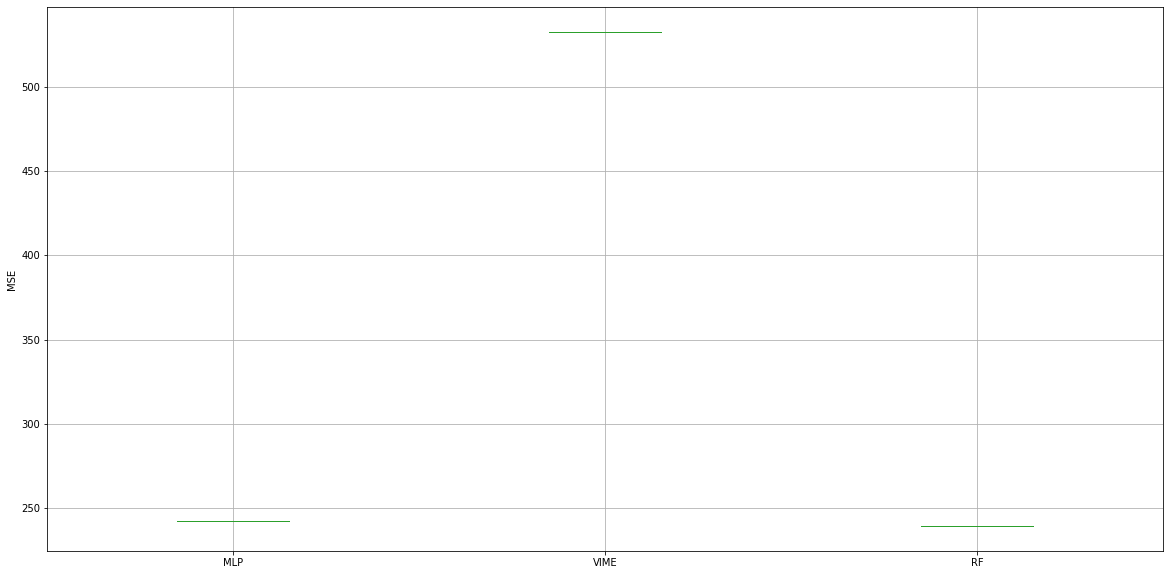

In [99]:
metrics_df = pd.DataFrame({"MLP": mlp_mses,
             "VIME": vime_mses[0],
             "RF": rf_mses[0]})

metrics_df.boxplot()
plt.ylabel("MSE")
plt.show()

In [100]:
metrics_df.describe()

,MLP,VIME,RF
count,1.000000,1.000000,1.000000
mean,242.168396,532.808961,239.228481
std,NaN,NaN,NaN
min,242.168396,532.808961,239.228481
25%,242.168396,532.808961,239.228481
50%,242.168396,532.808961,239.228481
75%,242.168396,532.808961,239.228481
max,242.168396,532.808961,239.228481
